# Analyse des mesures de l'ABmm

## Installations

#### Module de visualisation 3D Pyvista:
* avec pip: `pip install pyvista[all]`
* avec conda: `conda install -c conda-forge pyvista`

#### DataFrames avec pandas:
* `pip install pandas`
* `conda install pandas`

#### La bibliothèque d'optimisation lmfit
* `pip install lmfit`
* `conda install -c conda-forge lmfit`

In [2]:
import matplotlib.pyplot as plt
import read_measurements
import pandas as pd
import numpy as np
import pyvista as pv
import lmfit

## Lecture des fichiers de balayage rectangulaire

In [3]:
filepath = "exemples_mesures/xy_x0_7905_y0_24716_z0_300_step_05_60_x_60"

df = pd.read_csv(filepath, index_col=0, sep='\t')

data1 = read_measurements.Rectangular_sweep_data(df)

Pour accéder directement à la dataframe avec les mesures, on utilise `data1.df`.

In [17]:
data1.df

,x (m),y (m),Mesure ch1 (V),Mesure ch2 (V)
0,-0.0150,-0.015,4.7333,4.0167
1,-0.0145,-0.015,4.8382,3.9549
2,-0.0140,-0.015,4.8793,4.0555
3,-0.0135,-0.015,4.8618,3.9490
4,-0.0130,-0.015,4.8540,3.8681
...,...,...,...,...
3716,0.0130,0.015,4.3612,4.0736
3717,0.0135,0.015,4.3543,4.0857
3718,0.0140,0.015,4.2120,4.2672
3719,0.0145,0.015,4.3563,4.1097


Pour une première visualisation rapide des données:

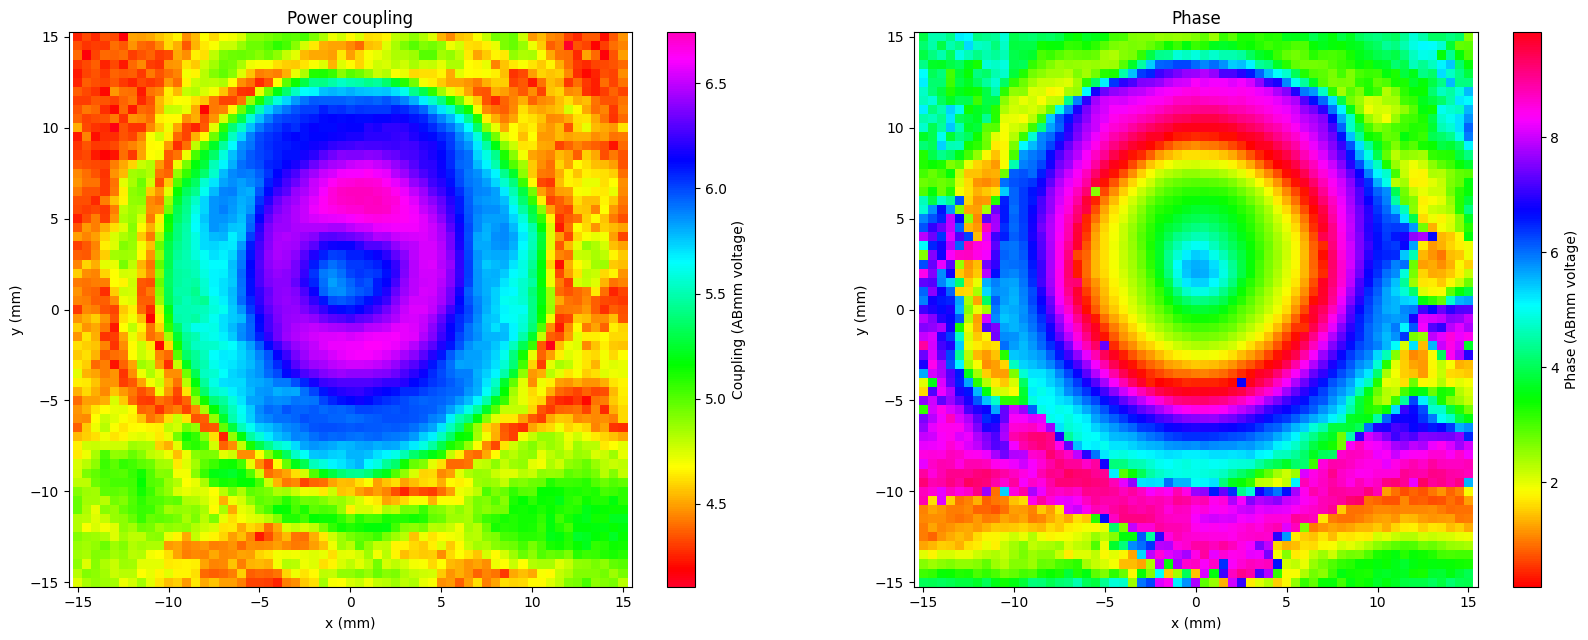

In [4]:
data1.plot()

Pour récupérer les données de la chaîne 1 (couplage) et de la chaine 2 (phase) sous forme de matrice:

In [5]:
couplage1 = data1.ndarray_ch1
phase1 = data1.ndarray_ch2

print(f"Matrice de données: \n{couplage1}")
print(f"Dimensions de la matrice: {couplage1.shape}")
print(f"Type: {type(couplage1)}")

Matrice de données: 
[[4.7333 4.8382 4.8793 ... 4.9102 4.9355 4.8145]
 [4.8135 4.911  4.8891 ... 4.9434 4.8572 4.9299]
 [4.8947 4.7422 4.9013 ... 4.8898 4.9782 4.9933]
 ...
 [4.3852 4.1709 4.3112 ... 4.1758 4.3449 4.495 ]
 [4.3398 4.2892 4.303  ... 4.3027 4.4023 4.4345]
 [4.2504 4.3293 4.2619 ... 4.212  4.3563 4.4733]]
Dimensions de la matrice: (61, 61)
Type: <class 'numpy.ndarray'>


On peut convertir les unités puis faire le même type d'affichage:

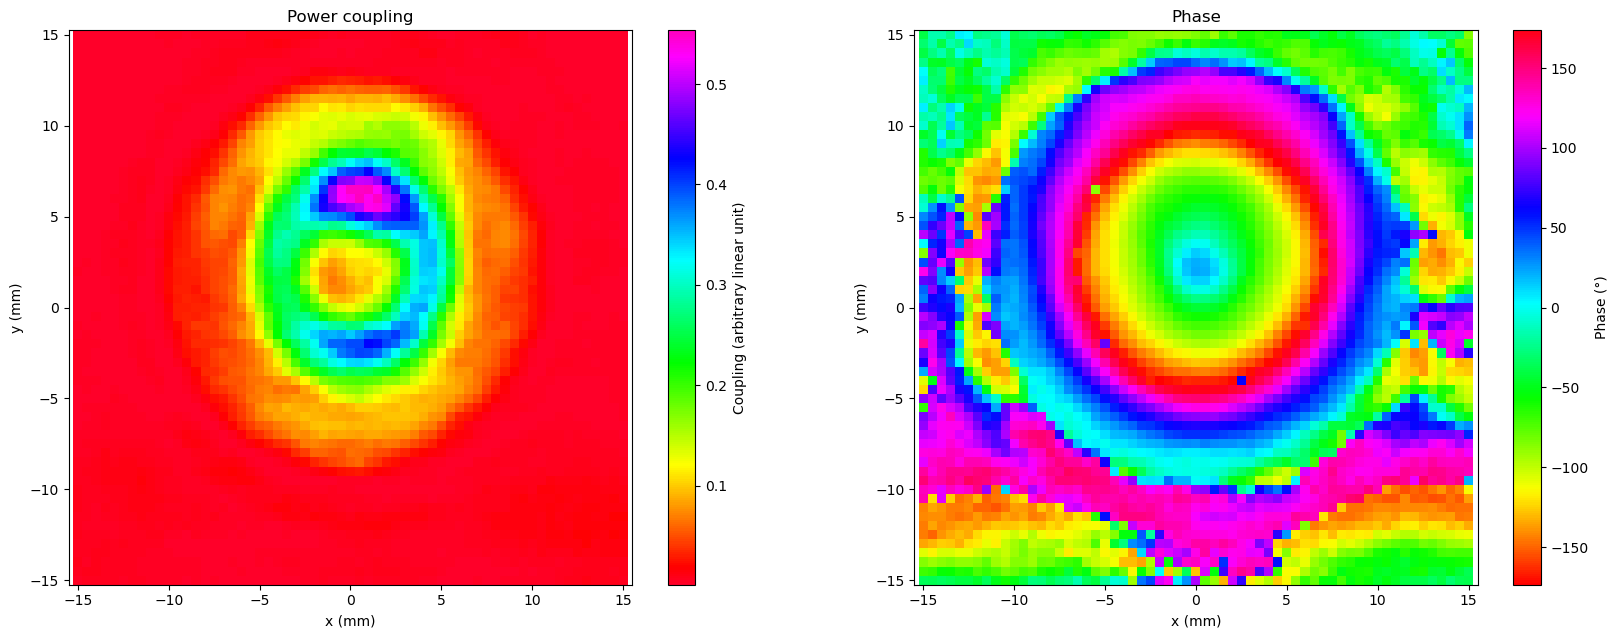

In [19]:
couplage1 = 10**(data1.ndarray_ch1-2)*1e-5 #Échelle linéaire arbitraire
phase1 = data1.ndarray_ch2 * 36 - 180 #En degrés

# On peut récupérer le meshing des données
X, Y = data1.X, data1.Y


fig = plt.figure(figsize=(20,7.2))
plt.subplot(1,2,1)
plt.pcolormesh(X*1e3, Y*1e3, couplage1, cmap='gist_rainbow')
plt.axis('equal')
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')
plt.title('Power coupling')
plt.colorbar(label='Coupling (arbitrary linear unit)')
plt.subplot(1,2,2)
plt.pcolormesh(X*1e3, Y*1e3, phase1, cmap='hsv')
plt.colorbar(label='Phase (°)')
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')
plt.axis('equal')
plt.title('Phase')
plt.show()


## Lecture de fichiers de mesures de balayage volumétrique

On récupère les données à partir du filepath:

In [25]:
df = pd.read_csv("exemples_mesures/xyz_x0_7905_y0_24716_z0_275_step_1_1_5", index_col=0, sep='\t')

data2 = read_measurements.Volumetric_sweep_data(df)

couplage2 = data2.ndarray_ch1
phase2 = data2.ndarray_ch2

print(f"Dimensions de la matrice: {couplage2.shape}")
print(f"Type: {type(couplage2)}")

Dimensions de la matrice: (61, 61, 11)
Type: <class 'numpy.ndarray'>


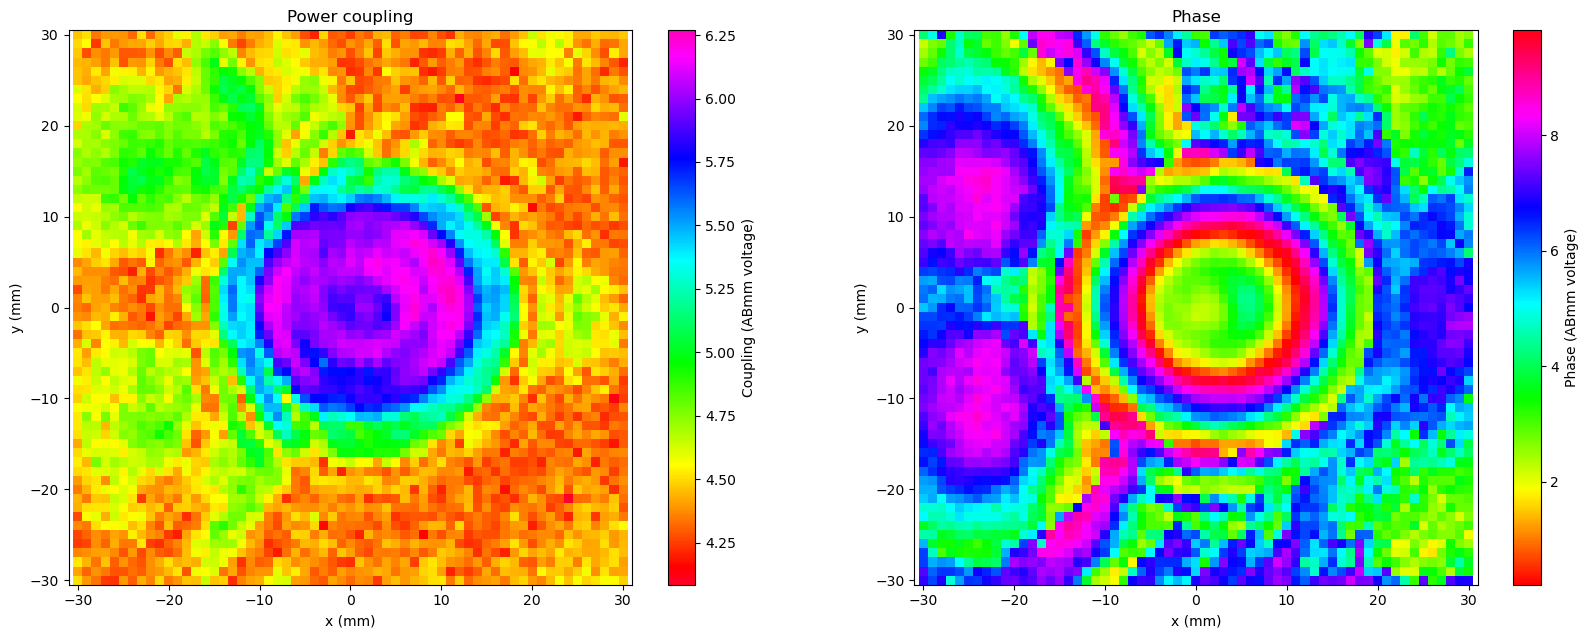

In [26]:
data3 = data2.get_rectangular_data(n_slice=4) #n_slice correspond à la couche selon z que l'on souhaite garder
data3.plot()

### Visualisation en 3D des fichiers volumétriques

Les deux fonctions suivantes permettent de visualiser les fonctions en 3D:
* `data2.plot_slices_mode()`
* `data2.plot_mri_mode()`

Ces fonctions ne fonctionnent pas encore dans un notebook... Pour plus d'info:

In [27]:
data2.plot_slices_mode?

In [10]:
data2.plot_mri_mode?

## Analyse d'un balayage en 1D perpendiculaire à l'axe de propagation:

<img src="figures/Montage_à_deux_récepteurs.png" width="300"/>


Pour deux faisceaux fondamentaux en champ lointain, le couplage en fonction de la position $x$ du deuxième faisceau sur l'axe vaut:
$$
K(x) = \exp\left[ -2 \left( \frac{x}{\delta_{off}}\right)^2\right]
$$

avec:

$$
\delta_{off} = \sqrt{\frac{(w_{0a}^2+w_{0b}^2)^2 + \left( \frac{\lambda \Delta z}{\pi}\right)^2}{w_{0a}^2+w_{0b}^2}}
$$

On récupère des données. 

Dimensions: 61, 61


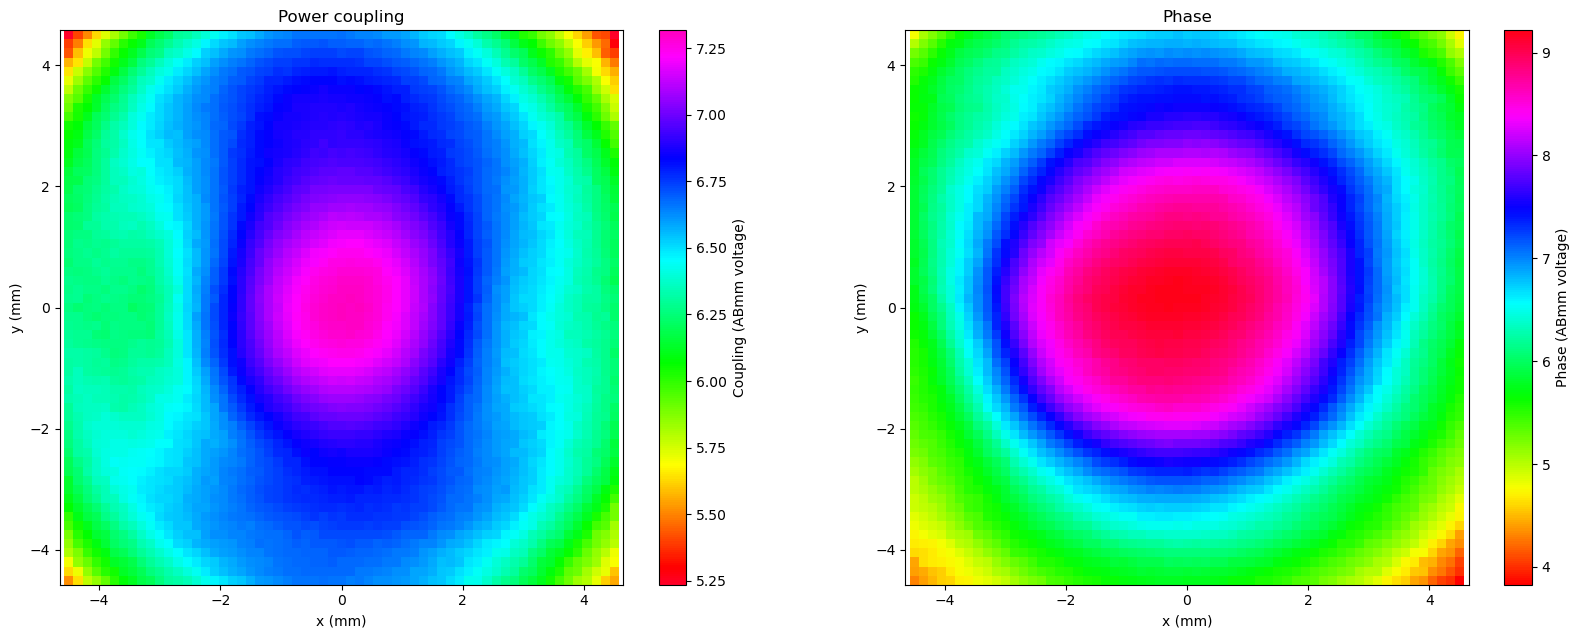

In [11]:
df = pd.read_csv("exemples_mesures/xy_x0_7838_y0_24436_z0_2761_x0lentille_70_step_015_015_61_61_points", 
                 index_col=0, 
                 sep='\t')
data3 = read_measurements.Rectangular_sweep_data(df)

print(f"Dimensions: {data3.Nx}, {data3.Ny}")

data3.plot()

On ne récupère qu'une tranche 1D selon $y$:

In [12]:
Y = data3.x_ * 1e3 # On va travailler en mm c'est plus pratique.
couplage = 10**(data3.ndarray_ch1[30,:]-2) * 1e-5

Pour faire un fit, on va utiliser la librairie `lmfit` qui est très complète. On construit d'abord notre fonction modèle:

$$
f(x) = P_0 \exp\left[ -2 \left( \frac{x-x_0}{\delta_{off}}\right)^2\right] + \text{offset}
$$

In [13]:
def model(x, delta_off, P0, x0, offset):
        return P0*(np.exp(-2*((x-x0)/delta_off)**2) + offset)

# On créer notre bibliothèque de paramètres
params = lmfit.Parameters()

# On lui ajoute les paramètres, avec une valeur initiale (value) et des bornes (min et max). 
# ATTENTION: les noms des variables doivent être les mêmes que ceux de la fonction.
params.add('delta_off', value=2, min=0)
params.add('P0', value=3, min=0)
params.add('x0', value=0)
params.add('offset', value=0.25)

# On créé notre modèle
Model = lmfit.Model(model)

# On le fait fitter en indiquant le jeu de données "couplage" et la plage de variables "Y".
result = Model.fit(couplage, x=Y, params=params)

L'avantage de la bibliothèque `lmfit` c'est qu'elle donne plein d'informations sur la convergence du fit:

In [14]:
result

On peut toujours vérifier si tout va bien au niveau du fit:

In [15]:
# Pour obtenir le jeu de variables optimal
result.params.valuesdict()

{'delta_off': 2.3637350486648034,
 'P0': 1.8710995023696801,
 'x0': 0.0805707097183488,
 'offset': 0.10025442937879897}

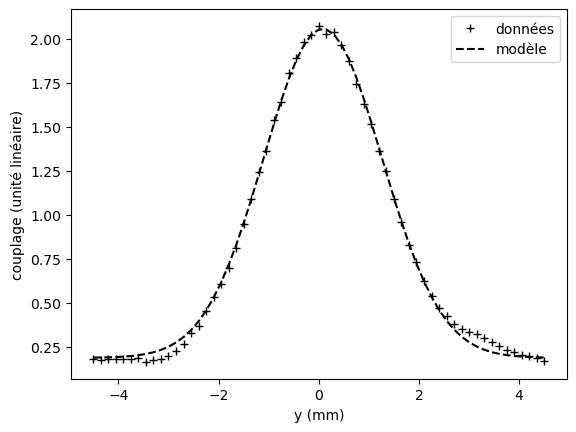

In [16]:
fit_model = model(Y, **result.params.valuesdict())

plt.plot(Y, couplage, 'k+', label='données')
plt.plot(Y, fit_model, 'k--', label='modèle')
plt.legend()
plt.xlabel('y (mm)')
plt.ylabel('couplage (unité linéaire)');

Dans ce cas précis, $\Delta z = 0$ donc on a $\delta_{off} = \sqrt{w_{0a}^2+w_{0b}^2}$.

Ainsi, avec $w_{0a}=2,3 mm$ le waist du cornet de réception, on a que:
$$
\begin{align}
    w_{0b} &= \sqrt{\delta_{off}^2 - w_{0a}^2} \\
           &= 530 \mu m
\end{align}
$$